In [23]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from silentsub.problem import SilentSubstitutionProblem
from silentsub.CIE import get_CIES026

In [24]:
# Functions for waveform
def get_time_vector(duration):
    t = np.arange(0, (duration*1000), 10).astype("int")
    return t


def sinusoid_modulation(f, duration, Fs=50):
    x = np.arange(duration*Fs)
    sm = np.sin(2 * np.pi * f * x / Fs)
    return sm


def modulate_intensity_amplitude(sm, background, amplitude):
    ivals = (background + (sm*amplitude)).astype("int")
    return ivals

In [114]:
# Set up calibration data
spds = pd.read_csv('../data/S2_corrected_oo_spectra.csv', index_col=['led', 'intensity'])
spds.index.rename(['Primary', 'Setting'], inplace=True)
spds.columns = pd.Int64Index(spds.columns.astype(int))
spds.columns.name = 'Wavelength'
spds = spds.sort_index()
spds

# list of colors for the primaries
colors = ['blueviolet', 'royalblue', 'darkblue', 'blue', 'cyan', 
          'green', 'lime', 'orange', 'red', 'darkred']

ss = SilentSubstitutionProblem(
    resolutions=[4095]*10,
    colors=colors,
    spds=spds,
    spd_binwidth=1,
    isolate=['S'],
    silence=['I', 'M', 'L'],
    )

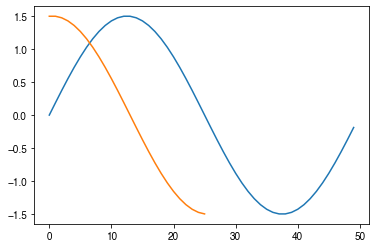

In [115]:
# Target contrast vals for modulation
contrast_waveform = sinusoid_modulation(1, 1, 50)*1.5
plt.plot(contrast_waveform)
peak = np.argmax(contrast_waveform)
trough = np.argmin(contrast_waveform)
target_contrasts = contrast_waveform[peak:trough+1]
plt.plot(target_contrasts)

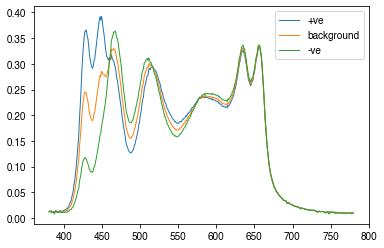

In [116]:
# Background is all channels at half power
bg_settings = np.array([.5]*10)

# Calcualte modulation spectra for S-cone modulation
contrast_mods = [ss.pseudo_inverse_contrast(bg_settings, [tc, 0, 0, 0, 0]) for tc in target_contrasts]
spectra = [bg_settings + mod for mod in contrast_mods]

plt.plot(ss.predict_multiprimary_spd(bg_settings+contrast_mods[0]), lw=1, label='+ve')
plt.plot(ss.predict_multiprimary_spd(bg_settings), lw=1, label='background')
plt.plot(ss.predict_multiprimary_spd(bg_settings+contrast_mods[-1]), lw=1, label='-ve')
plt.legend()


Modulation peak
---------------

	(array([ 0.0099507]), array([ 0.00970922,  0.00857956,  0.00592127]), array([ 0.21104595]))
	Background luminance: 18248.091718337455
	Modulation luminance: 18370.697907846097
	Background xy: [ 0.33326447  0.32618367]
	Modulation xy: [ 0.31977393  0.30153   ]


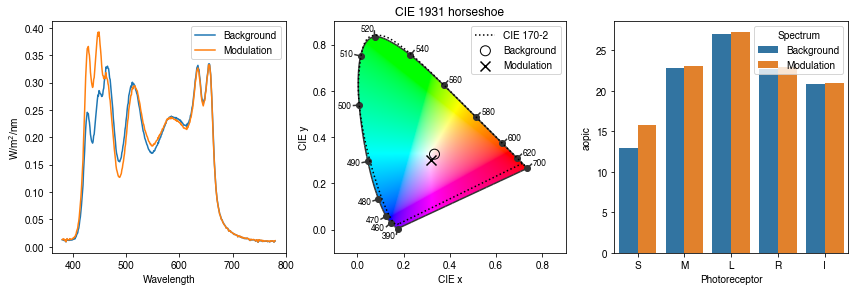

S-cone contrast: [ 0.21104595]
Splatter: [ 0.00970922  0.00857956  0.00592127]


In [120]:
ss.debug_callback_plot(np.hstack([bg_settings, spectra[0]]))
contrasts = ss.get_photoreceptor_contrasts(np.hstack([bg_settings, spectra[0]]))
print(f'S-cone contrast: {contrasts[2]}')
print(f'Splatter: {contrasts[1]}')

Modulation trough
-----------------

	(array([-0.00476087]), array([-0.00358463, -0.00366198, -0.00048466]), array([-0.20741836]))
	Background luminance: 18248.091718337455
	Modulation luminance: 18221.859506963217
	Background xy: [ 0.33326447  0.32618367]
	Modulation xy: [ 0.34960036  0.35565639]


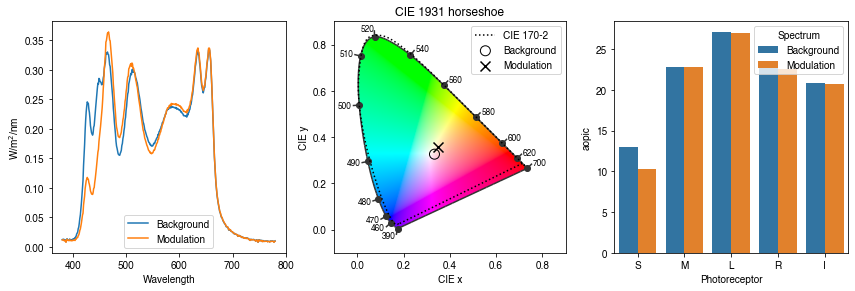

S-cone contrast: [-0.20741836]
Splatter: [-0.00358463 -0.00366198 -0.00048466]


In [121]:
ss.debug_callback_plot(np.hstack([bg_settings, spectra[-1]]))
contrasts = ss.get_photoreceptor_contrasts(np.hstack([bg_settings, spectra[-1]]))
print(f'S-cone contrast: {contrasts[2]}')
print(f'Splatter: {contrasts[1]}')

Modulation spectra for 50 Hz modulation
---------------------------------------

In [122]:
spectra

[array([ 0.79951112,  0.85526776,  0.44645639,  0.33541364,  0.34331443,
         0.54327744,  0.58437838,  0.43923695,  0.49256574,  0.50118077]),
 array([ 0.79951112,  0.85526776,  0.44645639,  0.33541364,  0.34331443,
         0.54327744,  0.58437838,  0.43923695,  0.49256574,  0.50118077]),
 array([ 0.79478765,  0.84966497,  0.44730081,  0.33800926,  0.34578545,
         0.54259493,  0.58304768,  0.44019522,  0.49268299,  0.50116215]),
 array([ 0.7854152 ,  0.83854776,  0.44897632,  0.34315958,  0.35068853,
         0.54124067,  0.58040727,  0.44209664,  0.49291562,  0.5011252 ]),
 array([ 0.77154159,  0.82209145,  0.45145651,  0.35078336,  0.35794635,
         0.53923602,  0.57649879,  0.44491124,  0.49325998,  0.5010705 ]),
 array([ 0.7533856 ,  0.80055556,  0.45470225,  0.36076038,  0.36744443,
         0.5366126 ,  0.57138388,  0.44859462,  0.49371064,  0.50099893]),
 array([ 0.73123357,  0.77427974,  0.45866237,  0.37293329,  0.37903299,
         0.53341177,  0.56514321,  0.45